## 1. Load raw data

In [1]:
import pandas as pd
import numpy as np

pd.set_option('display.max_columns', None)

In [ ]:
df_daily_rent = pd.read_csv("../data/raw/daily_rent_detail.csv")
df_weather = pd.read_csv("../data/raw/weather.csv")

/tmp/ipykernel_336528/1505384709.py:1: DtypeWarning: Columns (5,7) have mixed types. Specify dtype option on import or set low_memory=False.
  df_daily_rent = pd.read_csv("../data/raw/daily_rent_detail.csv")


## 2. Data Cleaning

In [ ]:
df_daily_rent_copy = df_daily_rent.copy()
df_weather_copy = df_weather.copy()

In [ ]:
df_daily_rent_copy.shape

(16086672, 13)

In [ ]:
# Check duplicated ride_id 
check_duplicates = df_daily_rent_copy.duplicated(subset="ride_id").sum()
print("Duplicated ride_id amount:", check_duplicates)

# Drop duplicated ride_id 
df_daily_rent_copy = df_daily_rent_copy.drop_duplicates(subset="ride_id", keep='first')

Duplicated ride_id amount: 141


In [ ]:
df_daily_rent_copy.shape

(16086531, 13)

In [ ]:
# 1. Calculate amount & percent
check_nan = df_daily_rent_copy.isna().sum()
check_nan_percent = df_daily_rent_copy.isna().mean() * 100

# 2. Merge to data frame
# axis=1 merge by col
nan_summary = pd.concat([check_nan, check_nan_percent], axis=1)

# 3. Set col name
nan_summary.columns = ["count", "percent"]

# 4. Display if nan amount > 0
display(nan_summary[nan_summary["count"] > 0])

,count,percent
start_station_name,1450130,9.014560
start_station_id,1450130,9.014560
end_station_name,1558227,9.686532
end_station_id,1558876,9.690567
start_lat,10,0.000062
start_lng,10,0.000062
end_lat,25916,0.161104
end_lng,25916,0.161104


In [ ]:
# Drop nan
df_daily_rent_copy = df_daily_rent_copy.dropna()

In [ ]:
df_daily_rent_copy.shape

(13928123, 13)

## 3. Data Integration

In [ ]:
# Retrive necessary features from raw data
df_weather_needs = df_weather_copy[["datetime","icon"]].copy()
df_daily_rent_needs = df_daily_rent_copy[["started_at"]].copy()

# Create necessary data by merging from raw data 
df_temp = pd.to_datetime(df_daily_rent_needs["started_at"], format="mixed")
df_daily_rent_needs["datetime"] = df_temp.dt.strftime("%Y-%m-%d")
df_final = pd.merge(df_daily_rent_needs, df_weather_needs, how="left", on="datetime")

In [ ]:
# Check if missing data after merging
assert df_daily_rent_copy.shape[0] == df_final.shape[0]

In [ ]:
# Save to
df_final.to_csv("../data/raw/final.csv", index=False)

KeyboardInterrupt: 

## 4. Feature engineering

In [2]:
df_raw = pd.read_csv("../data/raw/final.csv")

In [3]:
df = df_raw.copy()

In [4]:
# Create time from started_at
df_temp = pd.to_datetime(df["started_at"], format="mixed")
df["hour"] = df_temp.dt.strftime("%H").astype(int)

In [5]:
# Drop started_at 
df = df.drop(columns="started_at")

In [6]:
# Group by datetime & hour
df_hourly = df.groupby(["datetime", "hour"]).agg({"icon": "first"}).reset_index()

# Create usage col by counting 
counts = df.groupby(["datetime", "hour"]).size().reset_index(name="usage")

# Merge usage col into df_hourly
df_hourly = df_hourly.merge(counts, on=["datetime", "hour"])
df_hourly["hour"] = df_hourly["hour"].astype(int)
df_hourly.head()

,datetime,hour,icon,usage
0,2020-05-01,0,rain,9
1,2020-05-01,2,rain,4
2,2020-05-01,3,rain,1
3,2020-05-01,4,rain,4
4,2020-05-01,5,rain,10


In [7]:
# Create time-series dataframe for merging to create usage by hour in day
unique_dates = df["datetime"].unique()
df_date = pd.DataFrame({"datetime": unique_dates})

full_time_range = pd.date_range("00:00", "23:59", freq="min").strftime("%H").astype(int)
df_time = pd.DataFrame({"hour": full_time_range})

df_template = df_date.merge(df_time, how="cross")
df_template = df_template.drop_duplicates(["datetime","hour"]).reindex()

df_template.head()

,datetime,hour
0,2020-05-30,0
60,2020-05-30,1
120,2020-05-30,2
180,2020-05-30,3
240,2020-05-30,4


In [8]:
# Create new dataframe contain datetime, time, icon, usage (by hour in day) by merging
df_hourly["datetime"] = pd.to_datetime(df_hourly["datetime"])
df_template["datetime"] = pd.to_datetime(df_template["datetime"])

df_final = df_template.merge(df_hourly, on=["datetime","hour"], how="left").sort_values(["datetime","hour"])
df_final.head()

,datetime,hour,icon,usage
336,2020-05-01,0,rain,9.0
337,2020-05-01,1,NaN,NaN
338,2020-05-01,2,rain,4.0
339,2020-05-01,3,rain,1.0
340,2020-05-01,4,rain,4.0


In [9]:
# Create weather dict by datetime for mapping NaN values
df_weather_map = df_hourly[["datetime", "icon"]].drop_duplicates(subset="datetime").set_index("datetime")["icon"]
df_weather_map.head()

datetime
2020-05-01                 rain
2020-05-02    partly-cloudy-day
2020-05-03                 rain
2020-05-04                 rain
2020-05-05                 rain
Name: icon, dtype: object

In [10]:
# Fill NaN icon by mapping
df_final["icon"] = df_final["datetime"].map(df_weather_map)

# Fill NaN usage by zero
df_final["usage"] = df_final["usage"].fillna(0)
df_final.head()

,datetime,hour,icon,usage
336,2020-05-01,0,rain,9.0
337,2020-05-01,1,rain,0.0
338,2020-05-01,2,rain,4.0
339,2020-05-01,3,rain,1.0
340,2020-05-01,4,rain,4.0


In [11]:
# Create month, day, dow from datetime 
df_temp = pd.to_datetime(df_final["datetime"], format="mixed")
df_final["month"] = df_temp.dt.month.astype(int)
df_final["day"] = df_temp.dt.day.astype(int)
df_final["dow"] = df_temp.dt.day_name().str.lower().str[:3]

In [12]:
# Create season
season_map = {
    1: 'winter', 2: 'spring', 3: 'spring', 4: 'spring',
    5: 'summer', 6: 'summer', 7: 'summer',
    8: 'autumn', 9: 'autumn', 10: 'autumn',
    11: 'winter', 12: 'winter'
}

df_final["season"] = df_temp.dt.month.map(season_map)

In [13]:
# Create weekend 
df_final["weekend"] = df_final["dow"].isin(["sat", "sun"]).astype(int)

# Rearrange columns order
df_final = df_final[["datetime", "month", "day", "hour", "dow", "weekend", "season", "icon", "usage"]].reindex()

In [14]:
# Transform datetime to date_since
df_final["date_since"] = (df_final["datetime"] - df_final["datetime"].min()).dt.days
df_final =df_final.drop(columns="datetime")
df_final = df_final[["date_since", "month", "day", "hour", "dow", "weekend", "season", "icon", "usage"]].reindex()
df_final.head()

,date_since,month,day,hour,dow,weekend,season,icon,usage
336,0,5,1,0,fri,0,summer,rain,9.0
337,0,5,1,1,fri,0,summer,rain,0.0
338,0,5,1,2,fri,0,summer,rain,4.0
339,0,5,1,3,fri,0,summer,rain,1.0
340,0,5,1,4,fri,0,summer,rain,4.0


In [15]:
df_final.info()

<class 'pandas.core.frame.DataFrame'>
Index: 35808 entries, 336 to 35615
Data columns (total 9 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   date_since  35808 non-null  int64  
 1   month       35808 non-null  int64  
 2   day         35808 non-null  int64  
 3   hour        35808 non-null  int64  
 4   dow         35808 non-null  object 
 5   weekend     35808 non-null  int64  
 6   season      35808 non-null  object 
 7   icon        35808 non-null  object 
 8   usage       35808 non-null  float64
dtypes: float64(1), int64(5), object(3)
memory usage: 2.7+ MB


In [16]:
# Save to
df_final.to_csv("../data/processed/dataset.csv", index=False)

## 5. EDA

In [17]:
import math
from typing import List
import matplotlib.pyplot as plt
import seaborn as sns

class eda_plot:
    def __init__(self, 
                 data: pd.DataFrame, 
                 numerical_features: List, 
                 categorical_features: List,
                 target_feature: str,
                 n_col: int = 3):
        self.df = data
        self.numerical_features = numerical_features
        self.categorical_features = categorical_features
        self.target_feature = target_feature
        self.n_col = n_col

        self.numerical_col = self.numerical_features.append(self.target_feature)

    def plot_distribution_histogram(self):
        n_row = math.ceil(self.df.shape[1] / self.n_col)
        plt.figure(figsize=(5*self.n_col, 4*n_row))

        for index, feature in enumerate(self.numerical_features):
            plt.subplot(n_row, self.n_col, index + 1)
            mean_val = self.df[feature].mean()
            median_val = self.df[feature].median()

            sns.histplot(data=self.df, x=feature, color="skyblue", stat="density", label="Histogram")
            sns.kdeplot(data=self.df, x=feature, color="blue", linewidth="1.5", label="KDE (Density)")
            plt.axvline(mean_val, linestyle="--", color="green", label=f"Mean: {mean_val:.0f}")
            plt.axvline(median_val, linestyle="--", color="red", label=f"Median: {median_val:.0f}")

            plt.title(f"Distribution of {feature}", fontsize=14)
            plt.legend(loc="upper right")
            plt.xlabel(xlabel=f"{feature}")
        
        plt.tight_layout()
        plt.show()

    
    def plot_numerical_scattter_regline(self):
        n_row = math.ceil(len(self.numerical_features) / self.n_col)

        plt.figure(figsize=(5 * self.n_col, 4 * n_row))

        max_y_limit = self.df[self.target_feature].max() * 1.05

        for index, feature in enumerate(self.numerical_features):
            plt.subplot(n_row, self.n_col, index + 1)
            sns.scatterplot(data=self.df, x=feature, y=self.target_feature, color="blue", alpha= 0.2, edgecolor=None, label="Data point")
            sns.regplot(data=self.df, x=feature, y=self.target_feature, scatter=False, color="red", line_kws={'linestyle': '--'}, label="Linear fit")

            plt.ylim(0, max_y_limit)
            plt.title(f"Linear Regression: {self.target_feature.capitalize()} vs {feature}")
            plt.legend(loc="upper right")

        plt.tight_layout()
        plt.show()

    def plot_categorical_boxplots(self): 
        n_row = math.ceil(len(self.categorical_features) / self.n_col)
        plt.figure(figsize=(5 * self.n_col, 4* n_row))

        max_y_limit = self.df[self.target_feature].max() * 1.05

        for index, feature in enumerate(self.categorical_features):
            plt.subplot(n_row, self.n_col, index + 1)
            sns.boxplot(data=self.df, x=feature, y=self.target_feature, hue=feature, palette="plasma")

            plt.ylim(0, max_y_limit)
            plt.title(f"Distribution of {self.target_feature.capitalize()} by {feature}", fontsize=14)
            plt.legend(loc="upper right")

        plt.tight_layout()
        plt.show()
    
    def plot_correlation_matrix(self):
        correlation_matrix = self.df.corr(numeric_only=True)
        sns.heatmap(data=correlation_matrix, cmap="coolwarm", annot=True, vmin=-1, vmax=1, fmt=".2f")
        plt.title("Correlation Matrix")
        plt.tight_layout()
        plt.show()

In [18]:
numeric = ["hour", "month", "day"]
category = ["dow", "weekend", "icon"]
tar = "usage"
plotter = eda_plot(df_final, numeric, category, tar)

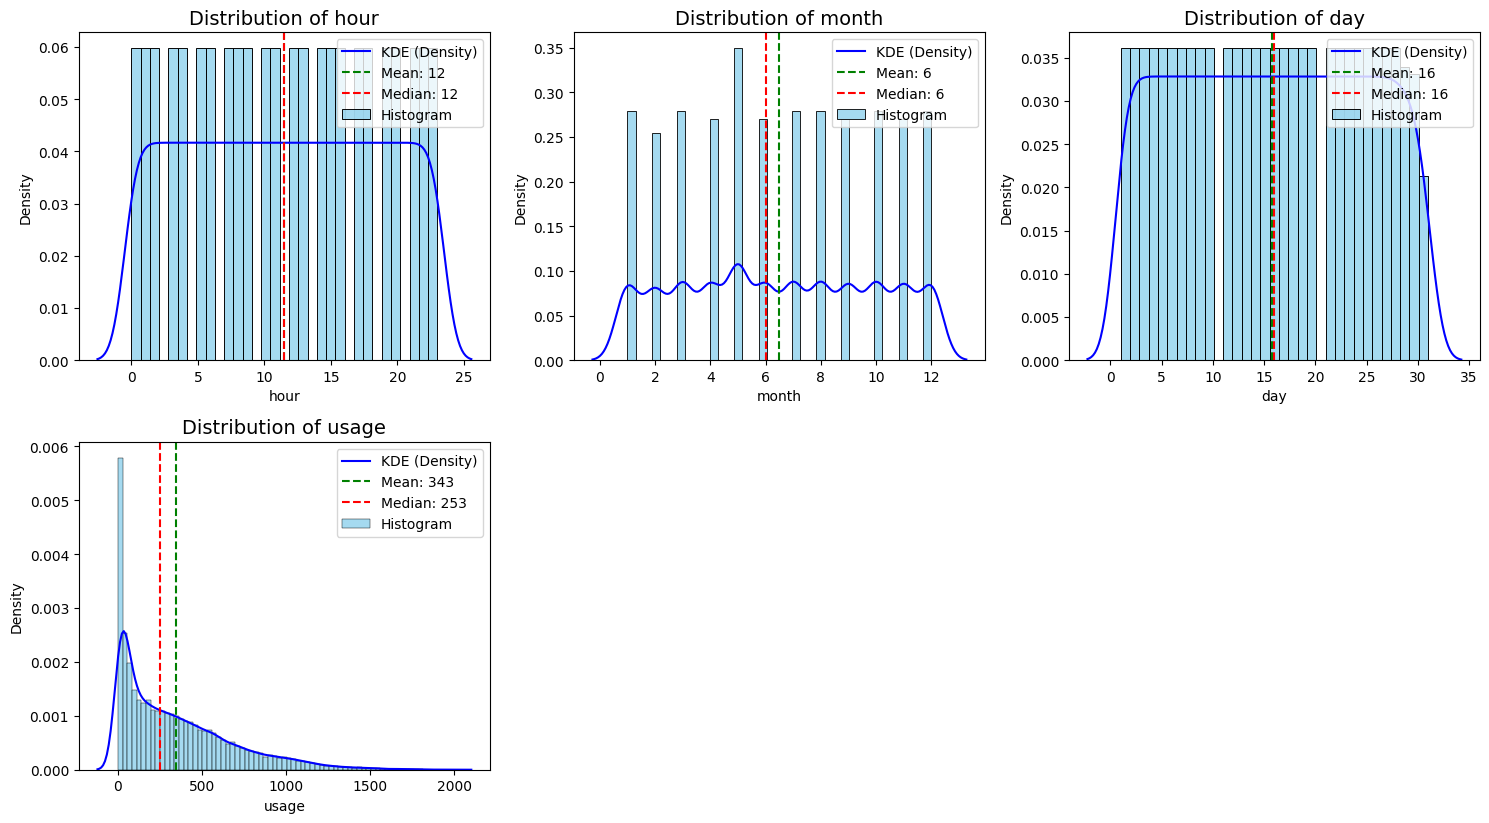

In [19]:
plotter.plot_distribution_histogram()

/tmp/ipykernel_364318/958837352.py:74: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend(loc="upper right")
/tmp/ipykernel_364318/958837352.py:74: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend(loc="upper right")


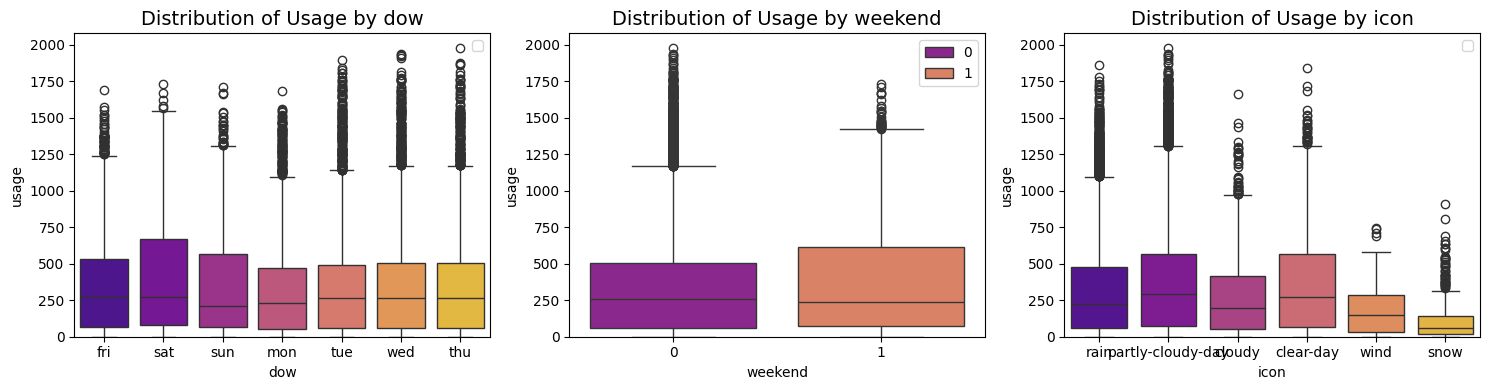

In [20]:
plotter.plot_categorical_boxplots()

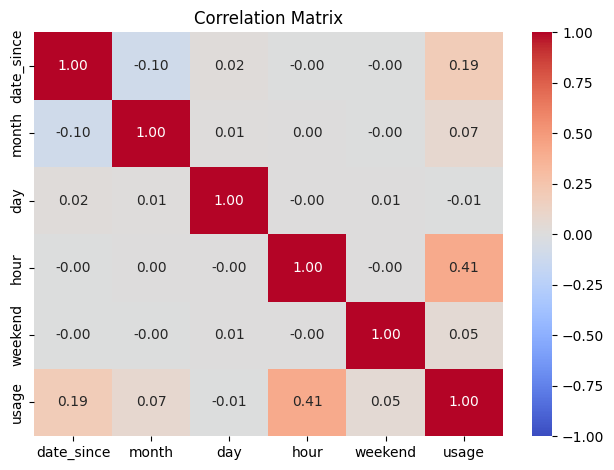

In [21]:
plotter.plot_correlation_matrix()

/tmp/ipykernel_364318/958837352.py:74: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend(loc="upper right")
/tmp/ipykernel_364318/958837352.py:74: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend(loc="upper right")


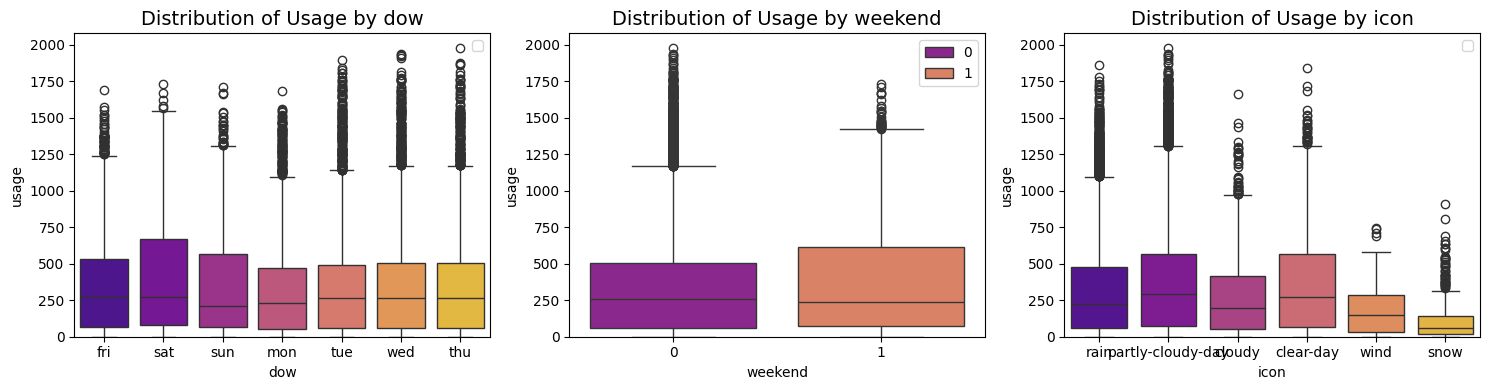

In [22]:
plotter.plot_categorical_boxplots()

## 6. Date Preprocessing

In [608]:
df = pd.read_csv("../data/processed/dataset.csv")
df.head()

,date_since,month,day,hour,dow,weekend,season,icon,usage
0,0,5,1,0,fri,0,summer,rain,9.0
1,0,5,1,1,fri,0,summer,rain,0.0
2,0,5,1,2,fri,0,summer,rain,4.0
3,0,5,1,3,fri,0,summer,rain,1.0
4,0,5,1,4,fri,0,summer,rain,4.0


In [717]:
df_poly = df.copy()

In [718]:
# Log transform for usage
log_feature = ["usage"]
df_poly[log_feature] = pd.DataFrame(np.log1p(df_poly[log_feature]))

In [719]:
# One-hot encoding for categorical features
categorical_cols = ["season", 'dow', 'icon']
valid_cat_cols = [c for c in categorical_cols if c in df_poly.columns]
df_poly = pd.get_dummies(df_poly, columns=valid_cat_cols, drop_first=True).astype(int)


In [720]:
from typing import List

def add_poly_features(data: pd.DataFrame, features: List[str], degree: int = 2) -> pd.DataFrame:
    for feature in features:
        for i in range(2, degree + 1):
            data[f"{feature}^{i}"] = data[feature]**i
    
    return data

def add_interaction_features(data: pd.DataFrame, 
                             primary_feature: str, 
                             interaction_features: List[str],
                             degree: int = 2) -> pd.DataFrame:
    
    add_poly_features(data, [primary_feature], degree)

    for feature in interaction_features:
        add_poly_features(data, [feature], degree)

        data[f"{primary_feature}_x_{feature}"] = data[primary_feature] * data[feature]
        
        for i in range(2, degree + 1):
            data[f"{primary_feature}^{i}_x_{feature}"] = data[primary_feature]**i * data[feature]
            
    return data

In [721]:
df_poly.columns

Index(['date_since', 'month', 'day', 'hour', 'weekend', 'usage',
       'season_spring', 'season_summer', 'season_winter', 'dow_mon', 'dow_sat',
       'dow_sun', 'dow_thu', 'dow_tue', 'dow_wed', 'icon_cloudy',
       'icon_partly-cloudy-day', 'icon_rain', 'icon_snow', 'icon_wind'],
      dtype='object')

In [722]:
primary_feature = "hour"
interaction_features = ["icon_cloudy","icon_partly-cloudy-day", "icon_rain", "icon_snow", "icon_wind"]
add_interaction_features(data=df_poly, primary_feature=primary_feature, interaction_features=interaction_features,degree=5)
add_interaction_features(data=df_poly,primary_feature=primary_feature,interaction_features=["weekend"], degree=4)
add_interaction_features(data=df_poly,primary_feature=primary_feature,interaction_features=["day"], degree=2)



,date_since,month,day,hour,weekend,usage,season_spring,season_summer,season_winter,dow_mon,dow_sat,dow_sun,dow_thu,dow_tue,dow_wed,icon_cloudy,icon_partly-cloudy-day,icon_rain,icon_snow,icon_wind,hour^2,hour^3,hour^4,hour^5,icon_cloudy^2,icon_cloudy^3,icon_cloudy^4,icon_cloudy^5,hour_x_icon_cloudy,hour^2_x_icon_cloudy,hour^3_x_icon_cloudy,hour^4_x_icon_cloudy,hour^5_x_icon_cloudy,icon_partly-cloudy-day^2,icon_partly-cloudy-day^3,icon_partly-cloudy-day^4,icon_partly-cloudy-day^5,hour_x_icon_partly-cloudy-day,hour^2_x_icon_partly-cloudy-day,hour^3_x_icon_partly-cloudy-day,hour^4_x_icon_partly-cloudy-day,hour^5_x_icon_partly-cloudy-day,icon_rain^2,icon_rain^3,icon_rain^4,icon_rain^5,hour_x_icon_rain,hour^2_x_icon_rain,hour^3_x_icon_rain,hour^4_x_icon_rain,hour^5_x_icon_rain,icon_snow^2,icon_snow^3,icon_snow^4,icon_snow^5,hour_x_icon_snow,hour^2_x_icon_snow,hour^3_x_icon_snow,hour^4_x_icon_snow,hour^5_x_icon_snow,icon_wind^2,icon_wind^3,icon_wind^4,icon_wind^5,hour_x_icon_wind,hour^2_x_icon_wind,hour^3_x_icon_wind,hour^4_x_icon_wind,hour^5_x_icon_wind,weekend^2,weekend^3,weekend^4,hour_x_weekend,hour^2_x_weekend,hour^3_x_weekend,hour^4_x_weekend,day^2,hour_x_day,hour^2_x_day
0,0,5,1,0,0,2,0,1,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,1,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0
1,0,5,1,1,0,0,0,1,0,0,0,0,0,0,0,0,0,1,0,0,1,1,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,1,1,1,1,1,1,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,1,1
2,0,5,1,2,0,1,0,1,0,0,0,0,0,0,0,0,0,1,0,0,4,8,16,32,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,1,1,1,2,4,8,16,32,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,2,4
3,0,5,1,3,0,0,0,1,0,0,0,0,0,0,0,0,0,1,0,0,9,27,81,243,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,1,1,1,3,9,27,81,243,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,3,9
4,0,5,1,4,0,1,0,1,0,0,0,0,0,0,0,0,0,1,0,0,16,64,256,1024,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,1,1,1,4,16,64,256,1024,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,4,16
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
35803,1491,5,31,19,0,5,0,1,0,0,0,0,0,0,0,0,0,0,0,0,361,6859,130321,2476099,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,961,589,11191
35804,1491,5,31,20,0,4,0,1,0,0,0,0,0,0,0,0,0,0,0,0,400,8000,160000,3200000,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,961,620,12400
35805,1491,5,31,21,0,4,0,1,0,0,0,0,0,0,0,0,0,0,0,0,441,9261,194481,4084101,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,961,651,13671
35806,1491,5,31,22,0,4,0,1,0,0,0,0,0,0,0,0,0,0,0,0,484,10648,234256,5153632,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,961,682,15004


In [723]:
# Get X (features), y (label)
y = df_poly["usage"]
X = df_poly.drop(columns="usage")

y.info()
X.info()

<class 'pandas.core.series.Series'>
RangeIndex: 35808 entries, 0 to 35807
Series name: usage
Non-Null Count  Dtype
--------------  -----
35808 non-null  int64
dtypes: int64(1)
memory usage: 279.9 KB
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 35808 entries, 0 to 35807
Data columns (total 78 columns):
 #   Column                           Non-Null Count  Dtype
---  ------                           --------------  -----
 0   date_since                       35808 non-null  int64
 1   month                            35808 non-null  int64
 2   day                              35808 non-null  int64
 3   hour                             35808 non-null  int64
 4   weekend                          35808 non-null  int64
 5   season_spring                    35808 non-null  int64
 6   season_summer                    35808 non-null  int64
 7   season_winter                    35808 non-null  int64
 8   dow_mon                          35808 non-null  int64
 9   dow_sat                    

In [724]:
# Convert to numpy array
y_array = y.values
X_array= X.values

In [725]:
def split_data(X: np.ndarray,
               y: np.ndarray,
               test_ratio: float = 0.2,
               seed: int = 42) -> tuple:
    
    data_size = X.shape[0]
    train_size = int(data_size * ( 1 - test_ratio))

    # Create a randomized index list
    np.random.seed(seed=seed)
    # indices = np.random.permutation(data_size)
    indices = np.arange(data_size)
    
    # Get index for train/test 
    train_indices = indices[:train_size]
    test_indices = indices[train_size:]

    # Split data by randomized index
    X_train, X_test = X[train_indices], X[test_indices] 
    y_train, y_test = y[train_indices], y[test_indices]
    
    return X_train, X_test, y_train, y_test

In [726]:
# Split dataset to Train/Test (Test size = 0.2)
X_train, X_test, y_train, y_test = split_data(X_array, y_array)

# Split Train dataset to Train/Valid (Valid size = 0.15)
X_train, X_valid, y_train, y_valid = split_data(X_train, y_train)

In [727]:
# MinMaxScaler for numerical features
import numpy as np

class MinMaxScaler:
    def __init__(self):
        self.min = None
        self.max = None
    
    def fit(self, data):
        self.min = np.min(data, axis=0)
        self.max = np.max(data, axis=0)

    def transform(self, data):
        if self.min is None or self.max is None:
            raise Exception(".fit() must be called before .transform()!")
        
        return (data - self.min) / (self.max - self.min)


    def fit_transform(self, data):
        self.fit(data)
        return self.transform(data)

In [728]:
# MinMax Scaling X_array
scaler = MinMaxScaler()
X_train_scaled = scaler.fit_transform(X_train)


In [729]:
def add_bias(X: np.ndarray) -> np.ndarray:
    X_bias = np.column_stack((np.ones(X.shape[0]), X))
    return X_bias

In [730]:
# Add Bias
X_train = add_bias(X_train_scaled)

## 7. Modeling

In [731]:
import numpy as np
import matplotlib.pyplot as plt

class PolynomialRidge:
    def __init__(self, X, y, epochs, batch_size, learning_rate, alpha):
        self.X = X
        self.y = y
        self.epochs = epochs
        self.batch_size = batch_size
        self.lr = learning_rate
        self.alpha = alpha
        self.data_size = X.shape[0]

        self.theta = np.random.randn(X.shape[1])
        self.loss = []
        self.accuracy = []

    def predict(self, X: np.ndarray) -> np.ndarray:
        result = X @ self.theta
        return result
    
    def r2_score(self, y: np.ndarray, y_predict: np.ndarray) -> np.floating:
        tss = np.sum((y - np.mean(y)) ** 2)
        rss = np.sum((y - y_predict) ** 2)

        return 1 - (rss / tss)

    def mse(self, y: np.ndarray, y_predict: np.ndarray) -> np.floating:
        mse = (y - y_predict) ** 2
        loss = np.mean(mse)

        return loss

    def fit(self):
        for epoch in range(self.epochs):
            print(f"--------------Epoch {epoch}--------------")
            # Get random index list
            # indices = np.random.permutation(self.data_size)
            indices = np.arange(self.data_size)

            # Create shuffled train data
            X_rand = self.X[indices]
            y_rand = self.y[indices]
            
            # Metrics epoch 
            loss_epoch = []
            r2_score_epoch = [] 

            for batch in range(0, self.data_size, self.batch_size):
                # Get train data for batch
                X_batch = X_rand[batch:batch + self.batch_size]
                y_batch = y_rand[batch:batch + self.batch_size]

                # Predict y
                y_predict = self.predict(X_batch)

                # Loss Ridge
                theta_ridge = self.theta.copy()
                theta_ridge[0] = 0

                loss_batch = self.mse(y_batch, y_predict) + self.alpha * np.sum(theta_ridge**2)
                loss_epoch.append(loss_batch)

                # R2score
                r2_score = self.r2_score(y_batch, y_predict)
                r2_score_epoch.append(r2_score)

                # Gradient
                error = y_predict - y_batch
                grad_mse = (2 / self.batch_size) * (X_batch.T @ error)
                grad_ridge = 2 * self.alpha * theta_ridge

                gradient = grad_mse + grad_ridge

                # Update weights
                self.theta = self.theta - self.lr * gradient
            
            np.set_printoptions(suppress=True, precision=4, linewidth=150)
            print(f"loss: {loss_epoch[-1]:.4f}")
            print(f"theta: {self.theta}")

            avg_loss = np.mean(loss_epoch)
            avg_r2 = np.mean(r2_score_epoch)

            self.loss.append(avg_loss)
            self.accuracy.append(avg_r2)

        result = {"status": "Completed",
                  "final_mse": self.loss[-1],
                  "final_r2": self.accuracy[-1]
                  }
        
        return result

    def plot(self):
        plt.figure(figsize=(10, 5))

        plt.subplot(1, 2, 1)
        plt.plot(self.loss, color="red")
        plt.xlabel("Epochs")
        plt.ylabel("RMSE")

        plt.subplot(1, 2, 2)
        plt.plot(self.accuracy, color="blue")
        plt.xlabel("Epochs")
        plt.ylabel("Accuracy")

        plt.show()

### 7.1. Fit model

In [732]:
model = PolynomialRidge(X_train, 
                         y_train,
                         epochs=350,
                         batch_size=256,
                         learning_rate=0.05,
                         alpha=0.001)

model.fit()

--------------Epoch 0--------------
loss: 1.2625
theta: [ 1.9673  0.1009  1.2927  1.0497  1.3371 -0.3859  1.2104  1.5337 -0.1908 -0.0134 -0.4764 -0.5982 -0.0389 -0.6441 -0.584  -0.3089 -0.3994  0.8046
 -1.0007 -1.3383  2.2415  0.0473  0.0289 -1.637  -0.2911  0.3583 -0.8923  0.6207 -0.4591 -0.2108 -0.5498  1.8638  0.0035 -0.4438  1.4196 -0.6055
  0.8114 -0.96   -0.7512  0.4575  0.8052  0.1243  0.3785  0.1947 -0.9722 -0.2203 -0.0724  1.1827  0.3251 -1.8462  0.1753 -0.4825 -0.7717  0.5053
  0.9209  0.8615 -0.8889 -0.3621  0.2745  0.9152 -0.4135 -0.1226 -1.035  -1.1241  0.832   1.3592 -0.062   1.0008  0.3627 -0.7932  0.2043  1.3704
  0.0328  1.5327 -2.6974  0.6617 -0.5538 -0.0913  0.0817]
--------------Epoch 1--------------
loss: 0.9725
theta: [ 2.018   0.1896  1.1805  0.8256  1.9192 -0.3829  0.9656  1.2386 -0.0912 -0.2068 -0.4565 -0.609  -0.1594 -0.3624 -0.3391 -0.2431 -0.4654  0.7522
 -0.9971 -1.2744  2.382  -0.1015 -0.2971 -2.0476 -0.2255  0.4181 -0.8213  0.6781 -0.4191 -0.199  -0.5497 

{'status': 'Completed',
 'final_mse': np.float64(0.7542287352596005),
 'final_r2': np.float64(0.6479343393402428)}

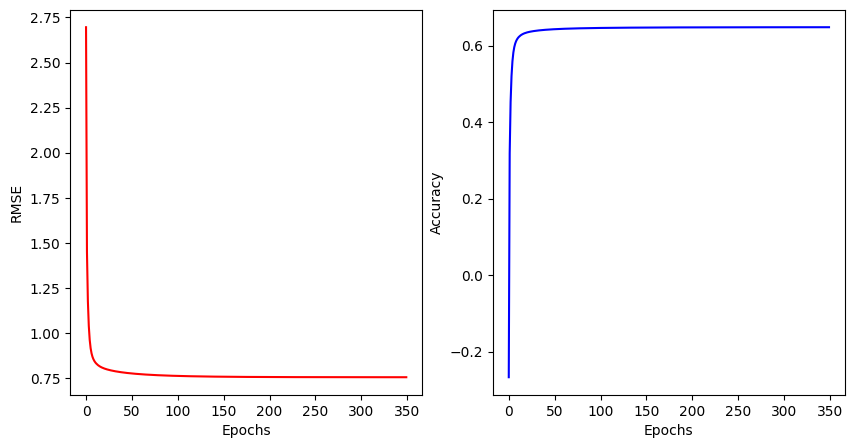

In [733]:
model.plot()

## 7.2. Validation

In [734]:
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

def plot_diagnostics(y_true, y_pred, name):
    # Compute Residuals = Actual - Predicted
    residuals = y_true - y_pred
    
    plt.figure(figsize=(18,8))

    # --- Actual vs Predicted ---'
    plt.subplot(1, 2, 1)
    sns.scatterplot(x=y_true, y=y_pred, color="blue", alpha=0.4)
    
    min_val = min(y_true.min(), y_pred.min())
    max_val = max(y_true.max(), y_pred.max())
    plt.plot([min_val, max_val], [min_val, max_val], "r--", linewidth=2)
    
    plt.title(f"{name}: Actual vs Predicted (Log Scale)", fontsize=14)
    plt.xlabel("Actual (Log Usage)", fontsize=12)
    plt.ylabel("Predicted (Log Usage)", fontsize=12)

    # --- Residual Plot ---
    plt.subplot(1, 2, 2)
    sns.scatterplot(x=y_pred, y=residuals, color="green", alpha=0.4)
    
    plt.axhline(y=0, color="red", linestyle="--", linewidth=2)
    
    plt.title(f"{name}: Residuals", fontsize=14)
    plt.xlabel("Log Usage", fontsize=12)
    plt.ylabel("Residuals", fontsize=12)

    plt.tight_layout()
    plt.show()

In [735]:
# MinMax scaling for X_valid 
X_valid_scaled = scaler.transform(X_valid)

# Add bias
X_valid = add_bias(X_valid_scaled)

In [736]:
# Validation
y_predict = model.predict(X_valid)
loss_valid = model.mse(y_valid, y_predict)
r2_valid = model.r2_score(y_valid, y_predict)

print(f"mse: {loss_valid}, r2: {r2_valid}")

mse: 0.9572746925818642, r2: 0.5688578711960772


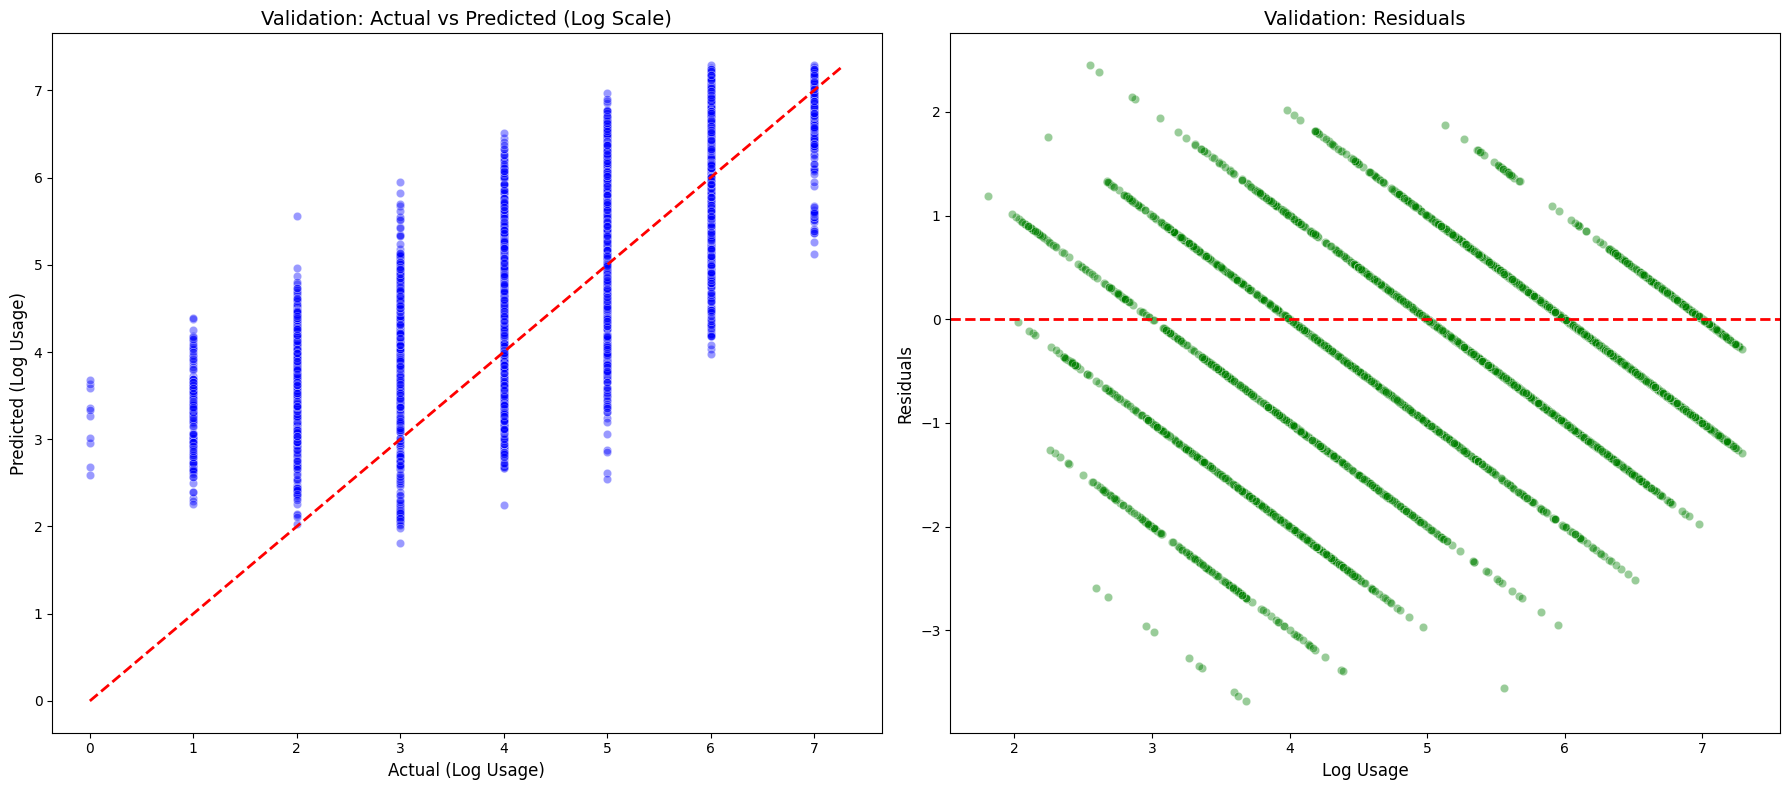

In [737]:
plot_diagnostics(y_valid, y_predict, "Validation")

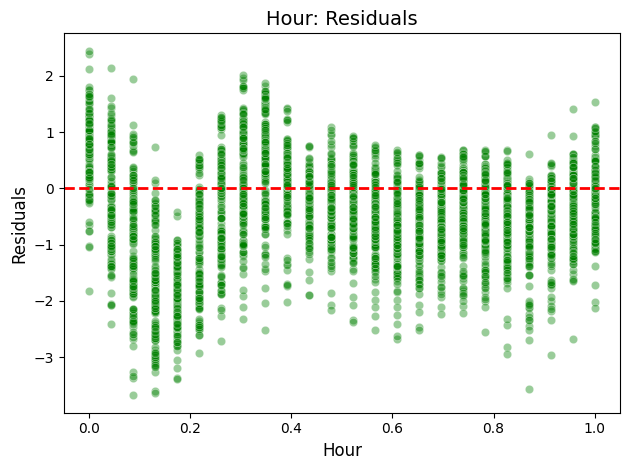

In [738]:
features = X_valid[:,4]


sns.scatterplot(x=features, y=(y_valid - y_predict), color="green", alpha=0.4)

plt.axhline(y=0, color="red", linestyle="--", linewidth=2)

plt.title(f"Hour: Residuals", fontsize=14)
plt.xlabel("Hour", fontsize=12)
plt.ylabel("Residuals", fontsize=12)

plt.tight_layout()
plt.show()

## 7.3. Testing

In [739]:
# MinMax scaling for X_test 
X_test_scaled = scaler.transform(X_test)

# Add bias
X_test = add_bias(X_test_scaled)

In [740]:
# Testing
y_predict = model.predict(X_test)
loss_test = model.mse(y_test, y_predict)
r2_test = model.r2_score(y_test, y_predict)

print(f"mse: {loss_test}, r2: {r2_test}")

mse: 1.8021592317472157, r2: 0.2612590337840589


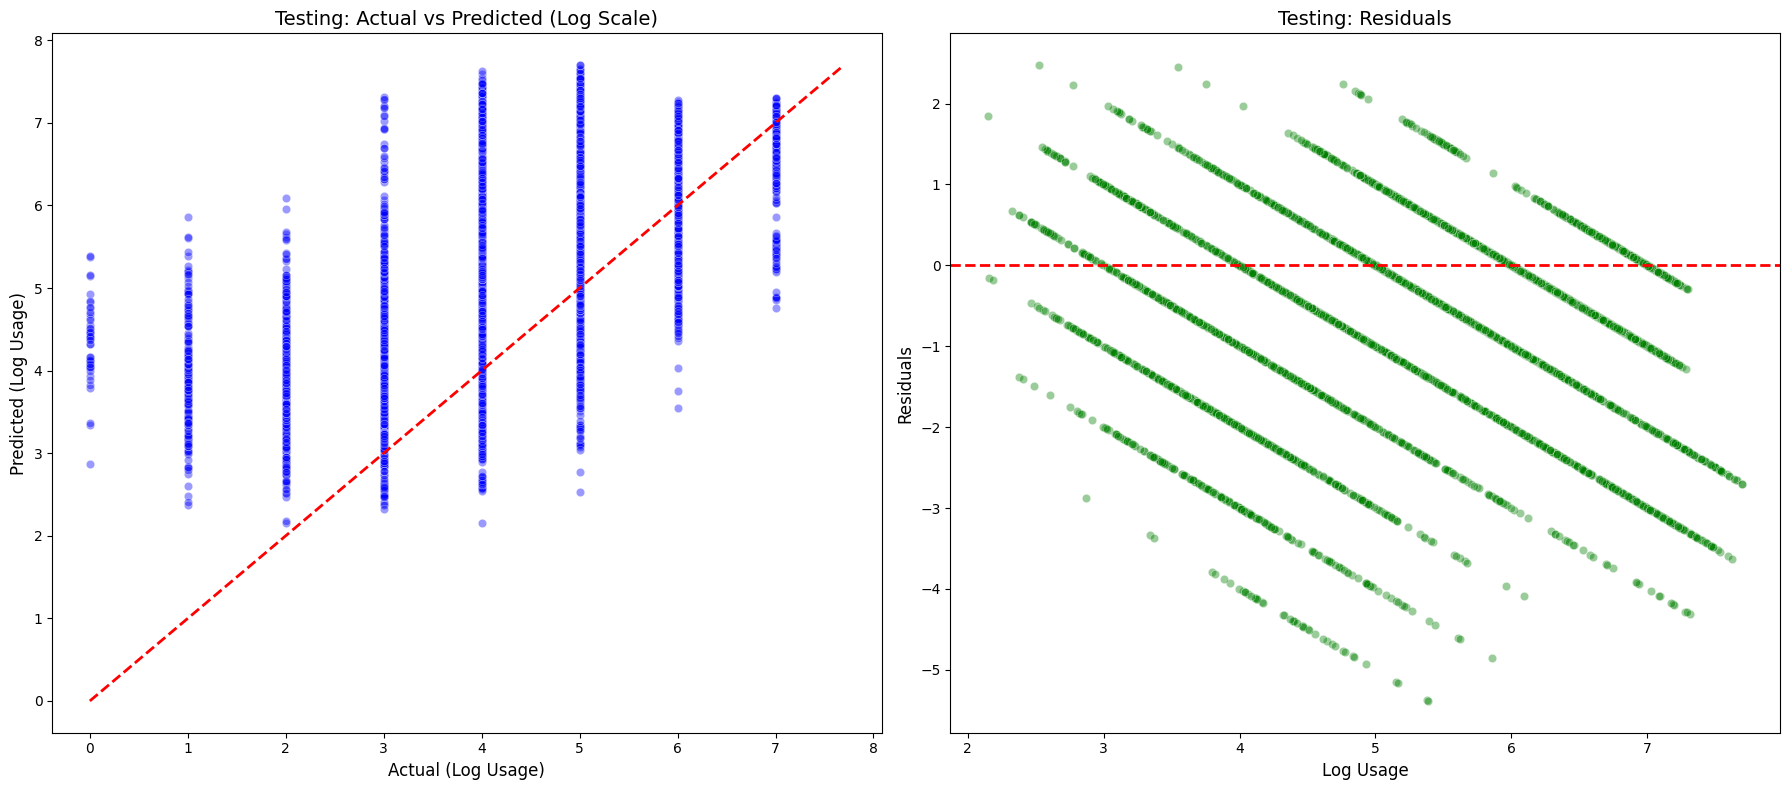

In [741]:
plot_diagnostics(y_test, y_predict, "Testing")

## 8. Evaluation

In [742]:
import pandas as pd
import numpy as np

def evaluate_model_performance(model, X_train, y_train, X_test, y_test):
    # 1. Model Predict
    y_train_pred_log = model.predict(X_train)
    y_test_pred_log = model.predict(X_test)
    
    # 2. Revert
    y_train_usd = np.expm1(y_train)
    y_test_usd = np.expm1(y_test)
    y_train_pred_usd = np.expm1(y_train_pred_log)
    y_test_pred_usd = np.expm1(y_test_pred_log)
    
    # 3. Compute Metrics
    def compute_metrics(y_true, y_pred, name):
        mse = model.mse(y_true, y_pred)
        rmse = np.sqrt(mse)
        mae = np.mean(np.abs(y_true - y_pred))
        r2 = model.r2_score(y_true, y_pred)
     
        mape = np.mean(np.abs((y_true - y_pred) / (y_true + 1e-5))) * 100
        
        return [name, r2, rmse, mae, mape]

    # 4. Sumarize
    metrics_train = compute_metrics(y_train_usd, y_train_pred_usd, "Train Set")
    metrics_test = compute_metrics(y_test_usd, y_test_pred_usd, "Test Set")
    
    df_metrics = pd.DataFrame([metrics_train, metrics_test], 
                              columns=["Dataset", "R2 Score", "RMSE", "MAE", "MAPE (%)"])
    
    return df_metrics, y_test_usd, y_test_pred_usd

In [743]:
df_results, y_test_real, y_test_pred = evaluate_model_performance(model, X_train, y_train, X_test, y_test)
display(df_results.round(2))

,Dataset,R2 Score,RMSE,MAE,MAPE (%)
0,Train Set,0.51,141.10,88.74,721397.54
1,Test Set,-0.82,367.77,231.12,5390635.98
